## LSTM Model EastRiver

### Set-up

In [6]:
# install pip
!pip install tensorflow==2.0.0b1
!pip install keras

     |████████████████████████████████| 317kB 2.8MB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,LSTM
# import matplotlib.pyplot as plt

seed = 7
np.random.seed(seed)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Using TensorFlow backend.


In [0]:
import tensorflow as tf
import pandas as pd
from pandas import Series,DataFrame

import io
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker

import collections

from keras import backend as k
# from tensorflow.python.framework import ops
# ops.reset_default_graph()

In [0]:
# install tensorflow==2.0.0b1
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Alldata_add_temp.csv to Alldata_add_temp (3).csv


### Process data

In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "Alldata_add_temp.csv" with length 227124 bytes


In [5]:
EastRiver = pd.read_csv(io.StringIO(uploaded['Alldata_add_temp.csv'].decode('utf-8')))
EastRiver.head()

,DateTime,discharge,kp_soilmoisture,jf_soilmoisture,ncrs380_swe,ncrs680_swe,ncrs380_rain,ncrs680_rain,nrcs380_temperature,nrcs680_temperature
0,2014-05-01,4.56823,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667
1,2014-05-02,4.54378,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333
2,2014-05-03,4.97784,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333
3,2014-05-04,6.07829,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833
4,2014-05-05,7.20931,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833


In [6]:
EastRiver['DateTime'] = pd.to_datetime(EastRiver['DateTime'])
EastRiver.set_index('DateTime', inplace=True)
EastRiver.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2014-05-01 to 2018-04-30
Data columns (total 9 columns):
discharge              1461 non-null float64
kp_soilmoisture        1461 non-null float64
jf_soilmoisture        1461 non-null float64
ncrs380_swe            1461 non-null float64
ncrs680_swe            1461 non-null float64
ncrs380_rain           1461 non-null float64
ncrs680_rain           1461 non-null float64
nrcs380_temperature    1461 non-null float64
nrcs680_temperature    1461 non-null float64
dtypes: float64(9)
memory usage: 114.1 KB


==============================================================

In [0]:
features = EastRiver.iloc[:, 2:]
labels = EastRiver.iloc[:, 1]

In [0]:
features.head()

,kp_soilmoisture,jf_soilmoisture,ncrs380_swe,ncrs680_swe,ncrs380_rain,ncrs680_rain,nrcs380_temperature,nrcs680_temperature
0,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667
1,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333
2,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333
3,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833
4,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833


In [0]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 8 columns):
kp_soilmoisture        1461 non-null float64
jf_soilmoisture        1461 non-null float64
ncrs380_swe            1461 non-null float64
ncrs680_swe            1461 non-null float64
ncrs380_rain           1461 non-null float64
ncrs680_rain           1461 non-null float64
nrcs380_temperature    1461 non-null float64
nrcs680_temperature    1461 non-null float64
dtypes: float64(8)
memory usage: 91.4 KB


In [0]:
labels.head()

0    4.56823
1    4.54378
2    4.97784
3    6.07829
4    7.20931
Name: discharge, dtype: float64

**Visualize the data**

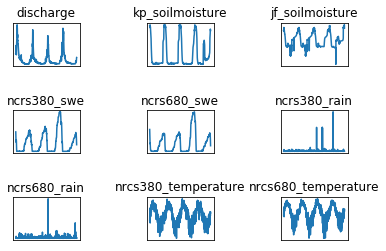

In [10]:
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8]
values = EastRiver.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(EastRiver.columns[i])

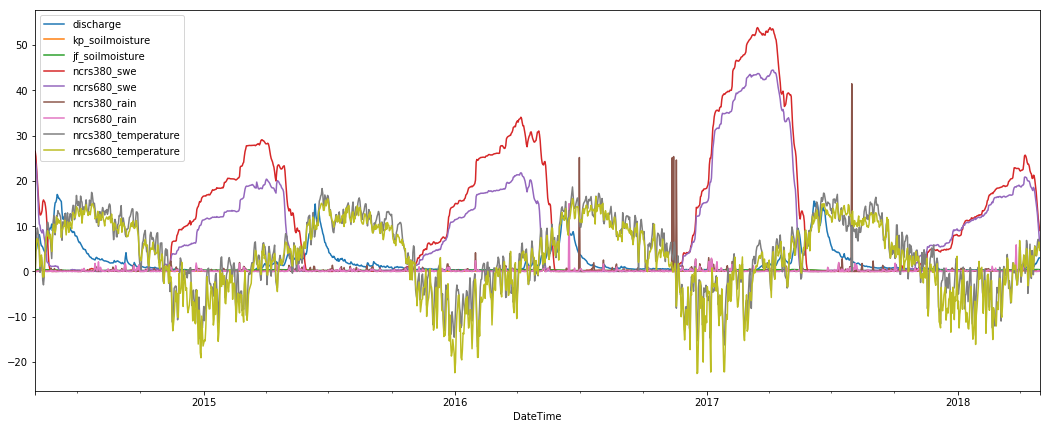

In [0]:
# EastRiver.set_index('DateTime', inplace=True)
EastRiver.plot(figsize=(18,7))

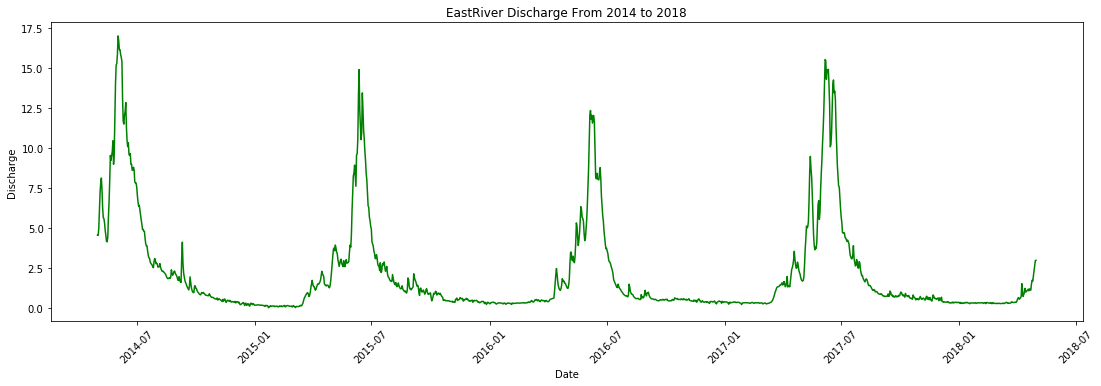

In [0]:
# create the plot space upon which to plot the data
fig, ax= plt.subplots()

# add the x-axis and the y-axis to the plot
ax.plot(EastRiver['DateTime'], 
        EastRiver['discharge'], 
        color = 'green')

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Discharge",
       title="EastRiver Discharge From 2014 to 2018");

# set plot size
fig.set_size_inches(18.5, 5.5)

### LSTM - treat as a univariate time series problem

In [28]:
Date = list(range(0, 1462))
Date[-1]

1461

In [0]:
series = labels.tolist()
series

In [30]:
series = np.array(labels, dtype=pd.Series)
series = pd.to_numeric(series,errors='coerce')
series

array([0.32447222, 0.32333333, 0.32002083, ..., 0.29336111, 0.2936875 ,
       0.29104167])

In [0]:
split_time = 1001
time = list(range(0, 1461))
# series = np.array(labels, dtype=pd.Series)
# series = pd.to_numeric(series,errors='coerce')

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1001,)
Epoch 1/100
4/4 [==============================] - 4s 914ms/step - loss: 4.9370 - mae: 5.3071
Epoch 2/100
4/4 [==============================] - 1s 319ms/step - loss: 4.9122 - mae: 5.2978
Epoch 3/100
4/4 [==============================] - 1s 315ms/step - loss: 4.8975 - mae: 5.2812
Epoch 4/100
4/4 [==============================] - 1s 305ms/step - loss: 4.8780 - mae: 5.2589
Epoch 5/100
4/4 [==============================] - 1s 307ms/step - loss: 4.8547 - mae: 5.2322
Epoch 6/100
4/4 [==============================] - 1s 310ms/step - loss: 4.8284 - mae: 5.2019
Epoch 7/100
4/4 [==============================] - 1s 322ms/step - loss: 4.7998 - mae: 5.1688
Epoch 8/100
4/4 [==============================] - 1s 313ms/step - loss: 4.7694 - mae: 5.1337
Epoch 9/100
4/4 [==============================] - 1s 306ms/step - loss: 4.7376 - mae: 5.0976
Epoch 10/100
4/4 [==============================] - 

[1e-08, 0.0001, 0, 60]

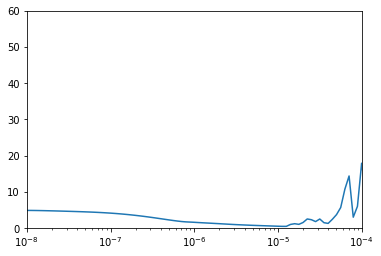

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# update the optimal learning rate, here lr is 10 to the minus 5
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 3s 342ms/step - loss: 4.3634 - mae: 4.9860
Epoch 2/150
10/10 [==============================] - 1s 112ms/step - loss: 1.6646 - mae: 2.1152
Epoch 3/150
10/10 [==============================] - 1s 111ms/step - loss: 0.8434 - mae: 1.2343
Epoch 4/150
10/10 [==============================] - 1s 111ms/step - loss: 0.6564 - mae: 1.0414
Epoch 5/150
10/10 [==============================] - 1s 113ms/step - loss: 0.4793 - mae: 0.8019
Epoch 6/150
10/10 [==============================] - 1s 115ms/step - loss: 0.4191 - mae: 0.7657
Epoch 7/150
10/10 [==============================] - 1s 111ms/step - loss: 0.3939 - mae: 0.7357
Epoch 8/150
10/10 [==============================] - 1s 111ms/step - loss: 0.3805 - mae: 0.7371
Epoch 9/150
10/10 [==============================] - 1s 113ms/step - loss: 0.2894 - mae: 0.5932
Epoch 10/150
10/10 [==============================] - 1s 112ms/step - loss: 0.2375 - mae: 0.4864
Epoch 11/150
10/10 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

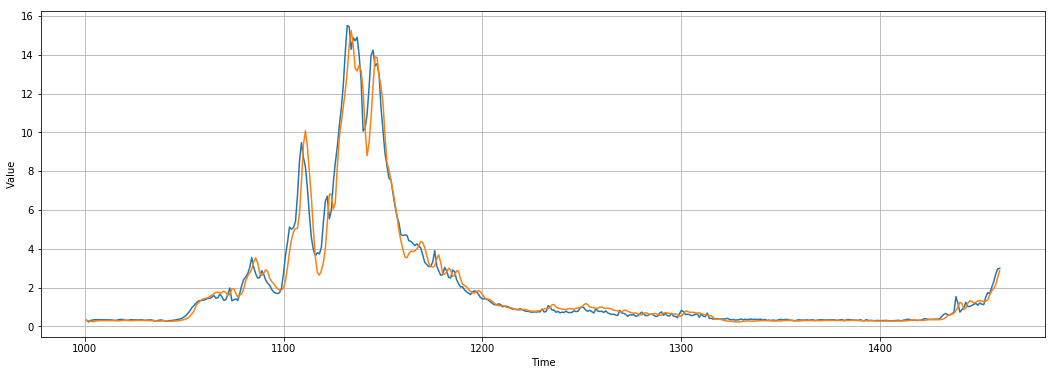

In [0]:
plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.2732538

In [0]:
print(rnn_forecast)

[ 0.30791944  0.29680562  0.26920584  0.25032008  0.26184595  0.2868838
  0.29665118  0.30190152  0.30339685  0.3040963   0.30324146  0.3018586
  0.30319792  0.3051451   0.30223572  0.29525667  0.28967386  0.2952373
  0.3092822   0.321914    0.320704    0.30952415  0.29830354  0.30048802
  0.3091237   0.31438503  0.31379348  0.31357828  0.31449822  0.3165403
  0.3114336   0.30128795  0.2986156   0.3045261   0.30613434  0.29169732
  0.27468538  0.27451897  0.28789157  0.29671532  0.29134762  0.2745135
  0.26641637  0.27023092  0.27720988  0.28326207  0.29452005  0.31007227
  0.329059    0.35373086  0.3904457   0.44479972  0.5377516   0.65830773
  0.81013346  1.0613236   1.2004135   1.2994593   1.3850236   1.4307747
  1.4523363   1.4852058   1.5487993   1.6214745   1.6848515   1.7617432
  1.7648163   1.7215564   1.7442597   1.81762     1.743017    1.5931284
  1.6587464   1.9335306   1.9548459   1.7093298   1.5204409   1.6139951
  1.6878022   1.9451784   2.3519115   2.6111748   2.759767  

In [0]:
len(rnn_forecast)


460

### LSTM - Treat as a multivariate problem

In [61]:
!pip uninstall tensorflow 

!pip uninstall keras

Uninstalling tensorflow-2.0.0b1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.0.0b1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.0.0b1
Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4


In [62]:
!pip install tensorflow==1.2.0
!pip install keras==2.0.9

  Using cached https://files.pythonhosted.org/packages/5e/55/7995cc1e9e60fa37ea90e6777d832e75026fde5c6109215d892aaff2e9b7/tensorflow-1.2.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: fancyimpute 0.4.3 requires keras>=2.0.0, which is not installed.
ERROR: tensorboard 1.14.0 has requirement markdown>=2.6.8, but you'll have markdown 2.2.0 which is incompatible.
ERROR: tb-nightly 1.14.0a20190603 has requirement markdown>=2.6.8, but you'll have markdown 2.2.0 which is incompatible.
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.2.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.2.0 which is incompatible.
  Found existing installation: Markdown 3.1.1
    Uninstalling Markdown-3.1.1:
      Successfully uninstalled Markdown-3.1.1


  Using cached https://files.pythonhosted.org/packages/b6/5a/c7fe49396e9d14f89b05ea550f3d5f8c4cfb3af20e831a3d323fec2a0d5b/Keras-2.0.9-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.9 which is incompatible.


In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

#### model build-up without considering lagging and previous label data (discharge)

In [7]:
EastRiver.head()

,discharge,kp_soilmoisture,jf_soilmoisture,ncrs380_swe,ncrs680_swe,ncrs380_rain,ncrs680_rain,nrcs380_temperature,nrcs680_temperature
DateTime,,,,,,,,,
2014-05-01,4.56823,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667
2014-05-02,4.54378,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333
2014-05-03,4.97784,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333
2014-05-04,6.07829,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833
2014-05-05,7.20931,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833


In [8]:
values = EastRiver.values

# ensure all data is float
values = values.astype('float64')
values

array([[ 4.56823015,  0.32447222,  0.35669444, ...,  0.        ,
        -0.73913043, -0.0916667 ],
       [ 4.54377985,  0.32333333,  0.35611806, ...,  0.        ,
         4.90000004,  4.33333332],
       [ 4.97783995,  0.32002083,  0.37296528, ...,  0.01058337,
         7.93333341,  6.53333335],
       ...,
       [ 2.69498049,  0.29336111,  0.41890972, ...,  0.2751663 ,
         7.08750008,  5.50833339],
       [ 2.96596768,  0.2936875 ,  0.40875694, ...,  0.02116675,
         6.21250009,  6.49166663],
       [ 2.99508346,  0.29104167,  0.38697222, ...,  0.05291657,
         5.97499997,  4.62916672]])

In [9]:
split_time = 1000

# use discharge as label and other columns as features
X = values[:,1:]
y = values[:,0]

x_train = X[:split_time,:]
x_test = X[split_time:,:]
y_train = y[:split_time]
y_test = y[split_time:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1000, 8) (461, 8) (1000,) (461,)


In [10]:
# reshape data to fit for lstm
# dimensions = (sample#, timeSteps, features)

timeSteps = 1
features = x_train.shape[1] # here's 8

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(1000, 1, 8) (461, 1, 8)


In [59]:
x_train.shape[2]

8

optimizer == "adam" with one hidden layer

In [0]:
model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "adam")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
test_time = list(range(split_time, split_time + y_test.shape[0]))
test_time

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

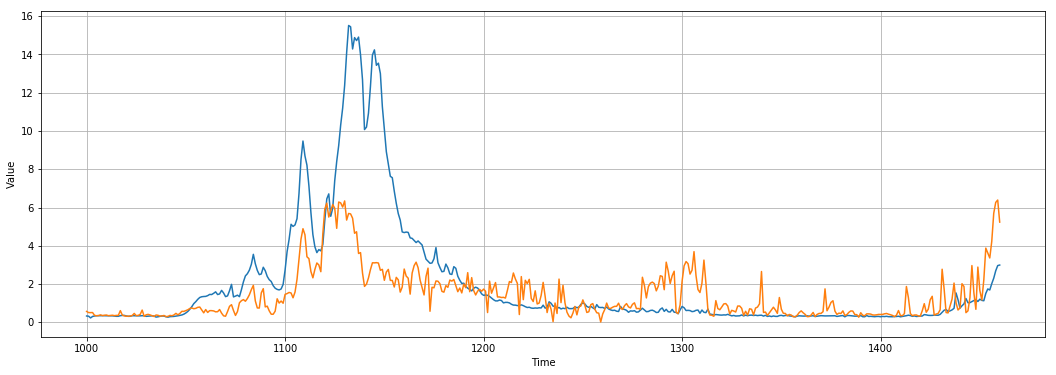

In [27]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

optimizer == "adam" with no hidden layer

In [0]:
model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "adam")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

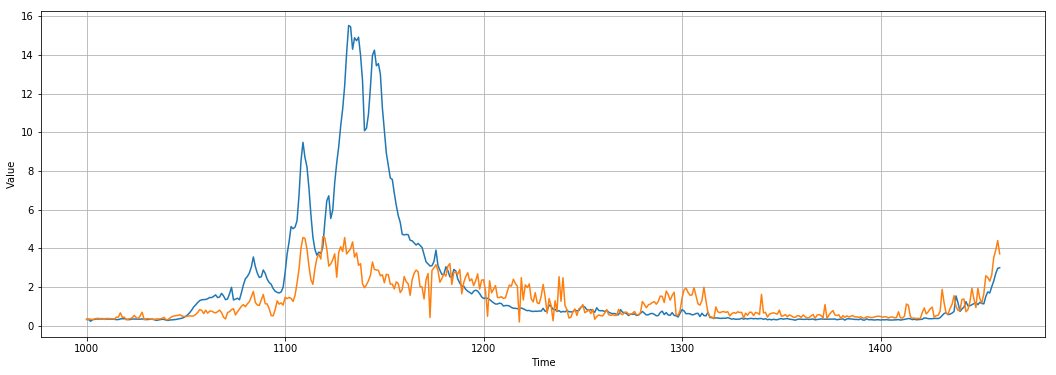

In [30]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

optimizer == "SGD" with one hidden layer



In [0]:
model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "sgd")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

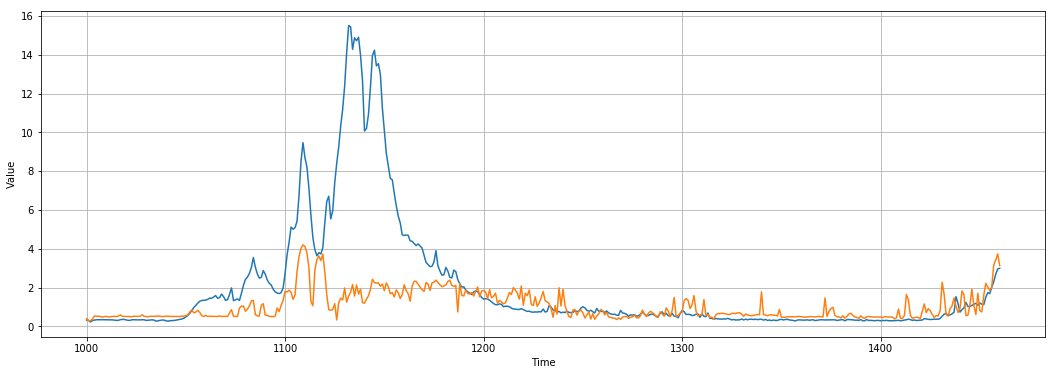

In [18]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

optimizer == "SGD" with no hidden layer

In [0]:
model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "sgd")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

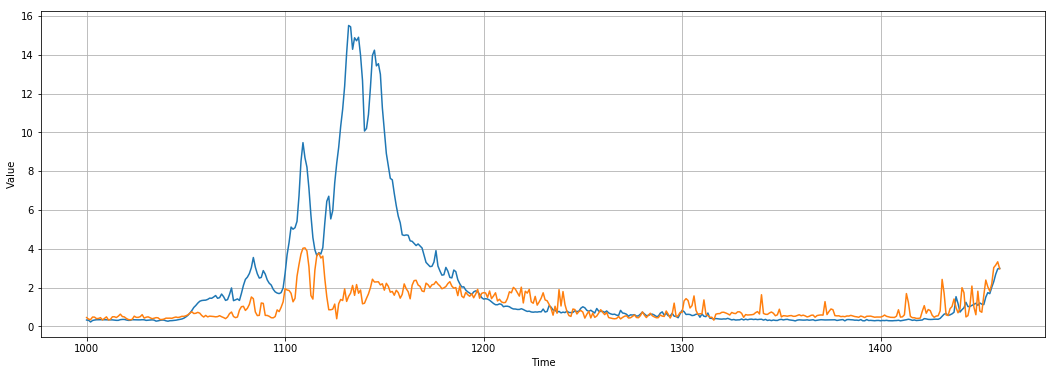

In [33]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

#### model build-up considering lagging and previous label data

In [38]:
values = EastRiver.values
values.shape[1]

9

In [36]:
# ensure all data is float
values = values.astype('float64')

array([[2.67283048e-01, 9.73574032e-01, 8.48150592e-01, ...,
        0.00000000e+00, 4.51304247e-01, 5.74970129e-01],
       [2.65840938e-01, 9.69535020e-01, 8.46780053e-01, ...,
        0.00000000e+00, 6.10921102e-01, 6.88257378e-01],
       [2.91442364e-01, 9.57787409e-01, 8.86839498e-01, ...,
        7.07549917e-04, 6.96780285e-01, 7.44580983e-01],
       ...,
       [1.56796360e-01, 8.63240075e-01, 9.96086524e-01, ...,
        1.83962034e-02, 6.72838782e-01, 7.18339305e-01],
       [1.72779535e-01, 8.64397597e-01, 9.71945176e-01, ...,
        1.41509983e-03, 6.48071711e-01, 7.43514247e-01],
       [1.74496821e-01, 8.55014286e-01, 9.20145309e-01, ...,
        3.53772934e-03, 6.41349217e-01, 6.95831198e-01]])

In [0]:
# normalize features (optional)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled

In [0]:
#convert data to supervised form

def to_supervised(data,dropNa = True,lag = timeSteps):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    
    # drop rows with missing values
    df.dropna(inplace = True)
    
    # specify columns for input and output pairs
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    
    return supervised_data

##### tryout with timeStep == 1

In [69]:
timeSteps = 1

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9
0,4.56823,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667,4.54378
1,4.54378,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333,4.97784
2,4.97784,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333,6.07829
3,6.07829,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833,7.20931
4,7.20931,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833,7.82067


In [51]:
EastRiver.shape[1]

9

In [70]:
# spiltting the data
# training on only first 1000 days' data

features = EastRiver.shape[1] # num of input features
train_hours = 1000

X = supervised[:,:features*timeSteps] # column 1-8
y = supervised[:,features*timeSteps] # column 9

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1000, 9) (460, 9) (1000,) (460,)


In [68]:
values.shape[1]

9

In [71]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 2, features here is 18)
timeSteps = 1
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(1000, 1, 9) (460, 1, 9)


optimizer == "adam" with no hidden layer

In [0]:
#define the model

model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "adam")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

In [0]:
test_time = list(range(split_time, split_time + y_test.shape[0]))
test_time

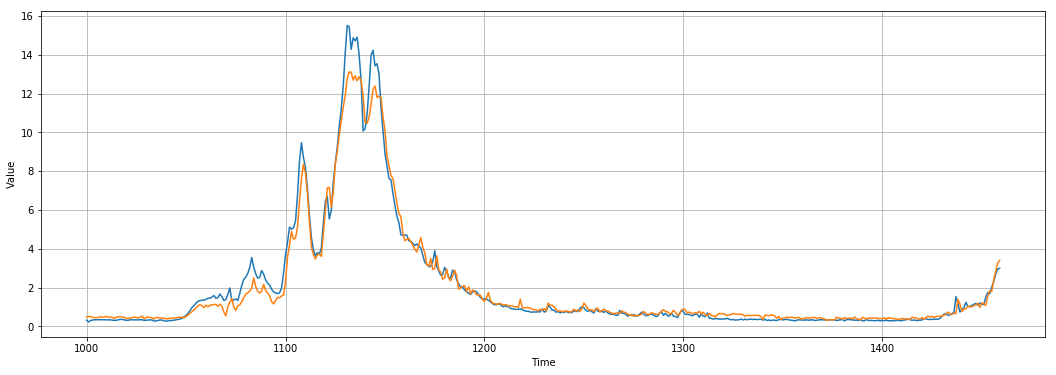

In [74]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [76]:
print ("mean absolute error: "),(mean_absolute_error(y_pred,y_test))
print ("mean squared error: "),(mean_squared_error(y_pred,y_test))

mean absolute error: 
mean squared error: 


(None, 0.24256681783172562)

if scaled(optional)

In [0]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

# concatenate the y or yhat column with the last 8 features of the test dataset in order to inverse the scaling
inv_new = np.concatenate((y_pred, x_test[:,-8:]), axis = 1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape(len(y_test), 1)

inv_new = np.concatenate((y_test, x_test[:,-8:]),axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [0]:
#plot the prediction with actual data
plt.figure(figsize = [18, 6])
plt.plot(final_pred, label = "prediction",c = "orange")
plt.plot(actual_pred,label = "actual data",c="teal")
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

In [0]:
final_pred = pd.to_numeric(final_pred,errors='coerce')
actual_pred = pd.to_numeric(actual_pred,errors='coerce')

In [59]:
print ("mean absolute error: "),(mean_absolute_error(final_pred,actual_pred))
print ("mean squared error: "),(mean_squared_error(final_pred,actual_pred))

mean absolute error: 
mean squared error: 


(None, 0.11965466683660611)

##### tryout with timeStep == 2

In [77]:
timeSteps = 2

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.56823,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667,4.54378,0.323333,0.356118,25.347083,23.622000,0.000000,0.000000,4.900000,4.333333,4.97784
1,4.54378,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333,4.97784,0.320021,0.372965,23.018750,21.992167,0.000000,0.010583,7.933333,6.533333,6.07829
2,4.97784,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333,6.07829,0.318597,0.388826,20.415250,19.526250,0.000000,0.000000,9.608333,7.270833,7.20931
3,6.07829,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833,7.20931,0.317035,0.392062,17.959917,16.457083,0.031750,0.052917,8.925000,6.795833,7.82067
4,7.20931,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833,7.82067,0.316646,0.392493,15.546917,12.456583,0.010583,0.063500,7.395833,5.716667,8.12635


In [78]:
# spiltting the data
# training on only first 1000 days' data

features = EastRiver.shape[1] # num of input features
train_hours = 1000

X = supervised[:,:features*timeSteps] # column 1-17
y = supervised[:,features*timeSteps] # column 18

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1000, 18) (459, 18) (1000,) (459,)


In [80]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 2, features here is 18)
timeSteps = 2
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(1000, 2, 9) (459, 2, 9)


optimizer == "adam" with no hidden layer

In [0]:
#define the model

model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "adam")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

In [0]:
test_time = list(range(split_time, split_time + y_test.shape[0]))
# test_time

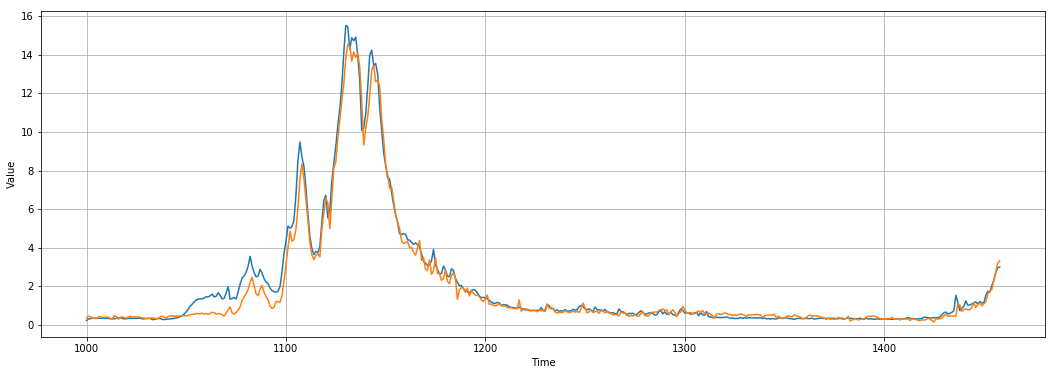

In [85]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [86]:
print ("mean absolute error: "),(mean_absolute_error(y_pred,y_test))
print ("mean squared error: "),(mean_squared_error(y_pred,y_test))

mean absolute error: 
mean squared error: 


(None, 0.21653053358480667)

##### tryout with timeStep == 5

In [87]:
timeSteps = 5

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0,4.56823,0.324472,0.356694,26.493304,24.595667,0.00000,0.000000,-0.739130,-0.091667,4.54378,0.323333,0.356118,25.347083,23.622000,0.000000,0.000000,4.900000,4.333333,4.97784,0.320021,0.372965,23.018750,21.992167,0.000000,0.010583,7.933333,6.533333,6.07829,0.318597,0.388826,20.415250,19.526250,0.000000,0.000000,9.608333,7.270833,7.20931,0.317035,0.392062,17.959917,16.457083,0.031750,0.052917,8.925000,6.795833,7.82067
1,4.54378,0.323333,0.356118,25.347083,23.622000,0.00000,0.000000,4.900000,4.333333,4.97784,0.320021,0.372965,23.018750,21.992167,0.000000,0.010583,7.933333,6.533333,6.07829,0.318597,0.388826,20.415250,19.526250,0.000000,0.000000,9.608333,7.270833,7.20931,0.317035,0.392062,17.959917,16.457083,0.031750,0.052917,8.925000,6.795833,7.82067,0.316646,0.392493,15.546917,12.456583,0.010583,0.063500,7.395833,5.716667,8.12635
2,4.97784,0.320021,0.372965,23.018750,21.992167,0.00000,0.010583,7.933333,6.533333,6.07829,0.318597,0.388826,20.415250,19.526250,0.000000,0.000000,9.608333,7.270833,7.20931,0.317035,0.392062,17.959917,16.457083,0.031750,0.052917,8.925000,6.795833,7.82067,0.316646,0.392493,15.546917,12.456583,0.010583,0.063500,7.395833,5.716667,8.12635,0.317118,0.382181,13.631333,10.456333,0.201083,0.179917,4.241667,5.029167,7.39272
3,6.07829,0.318597,0.388826,20.415250,19.526250,0.00000,0.000000,9.608333,7.270833,7.20931,0.317035,0.392062,17.959917,16.457083,0.031750,0.052917,8.925000,6.795833,7.82067,0.316646,0.392493,15.546917,12.456583,0.010583,0.063500,7.395833,5.716667,8.12635,0.317118,0.382181,13.631333,10.456333,0.201083,0.179917,4.241667,5.029167,7.39272,0.315292,0.374437,12.467167,10.117667,0.128381,0.084667,-0.208333,1.120833,6.26170
4,7.20931,0.317035,0.392062,17.959917,16.457083,0.03175,0.052917,8.925000,6.795833,7.82067,0.316646,0.392493,15.546917,12.456583,0.010583,0.063500,7.395833,5.716667,8.12635,0.317118,0.382181,13.631333,10.456333,0.201083,0.179917,4.241667,5.029167,7.39272,0.315292,0.374437,12.467167,10.117667,0.128381,0.084667,-0.208333,1.120833,6.26170,0.318486,0.381125,12.479131,9.038167,0.443121,0.031750,0.847826,1.825000,5.65645


In [88]:
EastRiver.shape[1] * timeSteps

45

In [89]:
# spiltting the data
# training on only first 1000 days' data

features = EastRiver.shape[1] # num of input features
train_hours = 1000

X = supervised[:,:features*timeSteps] # column 1-44
y = supervised[:,features*timeSteps] # column 45

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1000, 45) (456, 45) (1000,) (456,)


In [91]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 2, features here is 18)
timeSteps = 5
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(1000, 5, 9) (456, 5, 9)


optimizer == "adam" with no hidden layer

In [0]:
#define the model

model = Sequential()
model.add(LSTM(50,input_shape = (timeSteps,x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(1)) # 1 neuron in the output layer

model.compile(loss = "mae", optimizer = "adam")

history =  model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 150 , batch_size = 32, verbose = 0, shuffle = False)

In [0]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

In [0]:
test_time = list(range(split_time, split_time + y_test.shape[0]))
# test_time

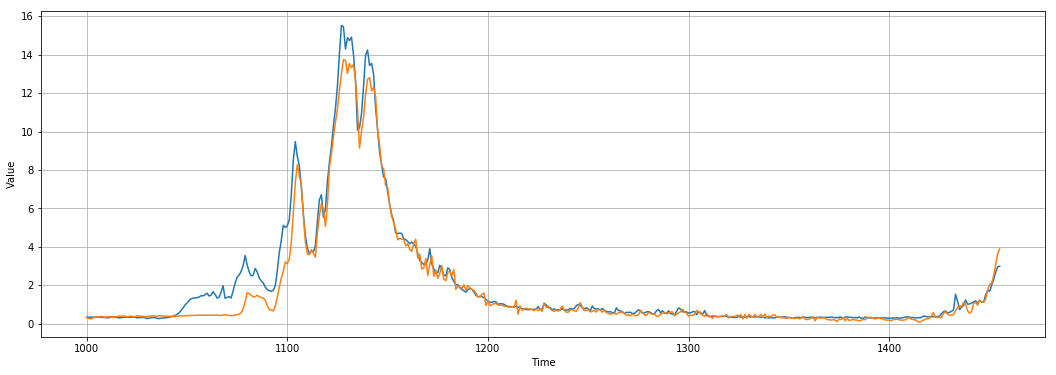

In [95]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [96]:
print ("mean absolute error: "),(mean_absolute_error(y_pred,y_test))
print ("mean squared error: "),(mean_squared_error(y_pred,y_test))

mean absolute error: 
mean squared error: 


(None, 0.3687660918536031)

##### conclusion: multivariate LSTM model with timeStep == 1 is optimal

## Other Failed Models

## First Model

In [0]:
X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=42)

In [0]:
# specify hyperparameters
epochs = 10
n_classes = 1000
n_units = 200 # hidden units
n_features = 8 
batch_size = 1

# define the place-holders for the batch of data
xplaceholder= tf.placeholder('float',[None,n_features])
yplaceholder = tf.placeholder('float')

In [0]:
def recurrent_neural_network_model():
    layer ={ 'weights': tf.Variable(tf.random_normal([n_units, n_classes])),'bias': tf.Variable(tf.random_normal([n_classes]))}

    x = tf.split(xplaceholder, n_features, 1)
    print(x)

    lstm_cell = rnn.BasicLSTMCell(n_units)
    
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
   
    output = tf.matmul(outputs[-1], layer['weights']) + layer['bias']

    return output

def train_neural_network():
    logit = recurrent_neural_network_model()
    logit = tf.reshape(logit, [-1])

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=yplaceholder))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:

        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

        for epoch in range(epochs):
            epoch_loss = 0

            i = 0
            for i in range(int(len(X_train) / batch_size)):

                start = i
                end = i + batch_size

                batch_x = np.array(X_train[start:end])
                batch_y = np.array(y_train[start:end])
                
                _, c = sess.run([optimizer, cost], feed_dict={xplaceholder: batch_x, yplaceholder: batch_y})
                epoch_loss += c
                i += batch_size

            print('Epoch', epoch, 'completed out of', epochs, 'loss:', epoch_loss)

        pred = tf.round(tf.nn.sigmoid(logit)).eval({xplaceholder: np.array(X_test), yplaceholder: np.array(y_test)})
        f1 = f1_score(np.array(y_test), pred, average='macro')
        accuracy=accuracy_score(np.array(y_test), pred)
        recall = recall_score(y_true=np.array(y_test), y_pred= pred)
        precision = precision_score(y_true=np.array(y_test), y_pred=pred)
        print("F1 Score:", f1)
        print("Accuracy Score:",accuracy)
        print("Recall:", recall)
        print("Precision:", precision)

In [0]:
tf.reset_default_graph()
train_neural_network()

[<tf.Tensor 'split_7:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split_7:7' shape=(?, 1) dtype=float32>]


ValueError: ignored

## Second Model

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from lstm_predictor import generate_data, load_csvdata, lstm_model

### Set-up

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn

import logging
logging.basicConfig(level=logging.INFO)

def x_sin(x):
    return x * np.sin(x)


def sin_cos(x):
    return pd.DataFrame(dict(a=np.sin(x), b=np.cos(x)), index=x)


def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [2, 3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)


def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test


def prepare_data(data, time_steps, labels=False, val_size=0.05, test_size=0.05):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))


def generate_data(fct, x, time_steps, seperate=False):
    """generates data with based on a function fct"""
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, val_y, test_y = prepare_data(data['b'] if seperate else data, time_steps, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

def load_csvdata(rawdata, time_steps, seperate=False):
    data = rawdata
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, val_y, test_y = prepare_data(data['b'] if seperate else data, time_steps, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

def lstm_model(time_steps, rnn_layers, dense_layers=None):
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param time_steps: the number of time steps the model will be looking at.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """

    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                               state_is_tuple=True),
                                                  layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                                state_is_tuple=True)
                    for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return learn.ops.dnn(input_layers, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = learn.ops.split_squeeze(1, time_steps, X)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        return learn.models.linear_regression(output, y)

In [0]:
LOG_DIR = './ops_logs'
TIMESTEPS = 10
RNN_LAYERS = [{'steps': TIMESTEPS}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100 # reset to 10000 or more loops
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

In [0]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y') # %H:%M
# rawdata = pd.read_csv("/content/Alldata_add_temp.csv", 
                   # parse_dates={'timeline': ['date', '(UTC)']}, 
                   # index_col='timeline', date_parser=dateparse)


X, y = load_csvdata(EastRiver, TIMESTEPS, seperate=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
y

In [0]:
regressor = learn.SKCompat(learn.Estimator(
    model_fn=lstm_model(
        TIMESTEPS,
        RNN_LAYERS,
        DENSE_LAYERS
    ),
    model_dir=LOG_DIR
))

W0806 19:35:50.422926 140631559899008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/learn/python/learn/estimators/estimator.py:1179: BaseEstimator.__init__ (from tensorflow.contrib.learn.python.learn.estimators.estimator) is deprecated and will be removed in a future version.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
W0806 19:35:50.424325 140631559899008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/learn/python/learn/estimators/estimator.py:427: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
W0806 19:35:50.426863 140631559899008 deprecation.py:323] From <ipython-input-61-a973bdfeeec1>:7: SKCompat.__init__ (from tensorflow.cont

In [0]:
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

predicted = regressor.predict(X['test'])

W0806 19:36:27.394085 140631559899008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/learn/python/learn/monitors.py:279: BaseMonitor.__init__ (from tensorflow.contrib.learn.python.learn.monitors) is deprecated and will be removed after 2016-12-05.
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
W0806 19:36:27.396357 140631559899008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/learn/python/learn/estimators/estimator.py:143: setup_train_data_feeder (from tensorflow.contrib.learn.python.learn.learn_io.data_feeder) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
W0806 19:36:27.397689 140631559899008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/learn/python/learn/learn_io/data_feeder.py:96: extract_dask_data (from tensorflow.contrib.learn.python.lear

TypeError: ignored

**Third Model**